## MIRI Coronographic data
Analysis of TWA 7 (Lagrange et al. 2025) : reduce data with JWST pipeline, explore stellar subtraction and measure contrast curves.

In [ ]:
#Useful package
import numpy as np
import glob, os
from astropy.io import fits
from tqdm.notebook import tqdm as tqdm
import matplotlib.pyplot as plt
from scipy import ndimage
import jwst
from astropy.visualization import simple_norm
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import scipy

# Personal importform ExoCAT
from utils import *
from miri_corono import *
from miri_photometry import *

### 1. Paths and useful parameters

In [2]:
name_system = 'TWA7' # It will be use to name the files
num_prog = '3662'

# Define paths :
path = f"/Users/mmalin/MIRI/Corono/DATA/{name_system}/" # data Directory
output_dir = path+name_system+f"_outputs/" # where to save the output

D = 6.57  # Diameter of the telescope
pix_size = 0.11 # arcsec/pixel
pixel_area = 2.84403609523084E-13

filter_name = 'F1140C'
nb_filters = len(filter_name)
wavelength_filter = 11.30
lambdaD_pix = ((wavelength_filter*10**-6)/6.57)*(180*3600/np.pi) / pix_size

# Number of the observations (useful to order, save & retrieve the data)
num_obs = [1,2,3,4,5] # science roll 1, roll 2, background, ref, ref background

# Center corono : DEC, RA 
yxc1065 = [112.00, 120.25]  
yxc1140 = [112.16, 119.77]
yxc1550 = [113.20, 119.73] 
yxc2330 = [167.88, 144.33]  
center_corono = yxc1140 # define the filter of the obs

### priors on the planet's position (if known)
RA_Offset = -1.1
Dec_Offset = 1.01

## 2. Data & Calibration with JWST pipeline

In [3]:
det1_dir = str(output_dir)+"stage1/" # Detector1 pipeline outputs will go here
cal2_dir = str(output_dir)+"stage2_photom/" # Spec2 pipeline outputs will go here
image2_dir = str(output_dir)+"stage2_no_photom/" # Spec2 pipeline but no photometric calibration

# We need to check that the desired output directories exist, and if not create them
if not os.path.exists(det1_dir):
    os.makedirs(det1_dir)
if not os.path.exists(image2_dir):
    os.makedirs(image2_dir)
if not os.path.exists(cal2_dir):
    os.makedirs(cal2_dir)

#### 2.1. STAGE 1

In [4]:
files_uncal = np.concatenate([sorted(glob.glob(path+f"uncal/jw0{num_prog}00*001_02101_00001_mirimage_uncal.fits"))])
print('Found ' + str(len(files_uncal)) + ' input files to process')

# RUN STAGE 1
# no parallelized version
for i in files_uncal:
    detector1(i,det1_dir)
    
# parallelized version because it's too long !   
# Parallel(n_jobs=2)(delayed(detector1)(i,det1_dir) for i in files_uncal)

Found 0 input files to process


#### 2.2. STAGE  2 

In [5]:
# Retrieve from stage 1 directory :
files_rate_roll1 = sorted(glob.glob(det1_dir+f"jw0{num_prog}00{num_obs[0]}001_04101_*_mirimage_rate.fits"))
files_rate_roll2 = sorted(glob.glob(det1_dir+f"jw0{num_prog}00{num_obs[1]}001_04101_*_mirimage_rate.fits"))

files_bkg_rate = sorted(glob.glob(str(det1_dir)+f"jw0{num_prog}00{num_obs[2]}001_02101_*_mirimage_rate.fits"))

files_ref_rate = sorted(glob.glob(str(det1_dir)+f"jw0{num_prog}00{num_obs[3]}001_04101_*_mirimage_rate.fits"))
files_ref_bkg_rate = sorted(glob.glob(str(det1_dir)+f"jw0{num_prog}00{num_obs[4]}001_02101_*_mirimage_rate.fits"))

# Target Aquisition files (TA) can be useful for custom calibration  (here just with the first roll)
files_TA = sorted(glob.glob(str(det1_dir)+f"jw0{num_prog}00{num_obs[0]}001_02101_*_mirimage_rate.fits")) 

# New Directories
if not os.path.exists(cal2_dir+f"obs{num_obs[0]}/"):
    os.makedirs(cal2_dir+f"obs{num_obs[0]}/")
if not os.path.exists(cal2_dir+f"obs{num_obs[1]}/"):
    os.makedirs(cal2_dir+f"obs{num_obs[1]}/")
if not os.path.exists(cal2_dir+f"obs{num_obs[3]}/"):
    os.makedirs(cal2_dir+f"obs{num_obs[3]}/")
    
# Liste ASN with science and bkg files + Run the pipeline
asnlist_roll1 = writeasnfile(files_rate_roll1, files_bkg_rate, name_system)
image2_cal(asnlist_roll1, cal2_dir+f"obs{num_obs[0]}/")

asnlist_roll2 = writeasnfile(files_rate_roll2, files_bkg_rate, name_system)
image2_cal(asnlist_roll2, cal2_dir+f"obs{num_obs[1]}/")

#Same for ref files
asnlist_ref = writeasnfile(files_ref_rate, files_ref_bkg_rate, name_system)
image2_cal(asnlist_ref,cal2_dir+f"obs{num_obs[0]}/")

2025-02-25 17:12:14,315 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.
2025-02-25 17:12:14,316 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2025-02-25 17:12:14,316 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2025-02-25 17:12:14,317 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.
2025-02-25 17:12:14,318 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.
2025-02-25 17:12:14,318 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.
2025-02-25 17:12:14,369 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args ('TWA7_lvl2_asn.json',).
2025-02-25 17:12:14,373 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/mmalin/MIRI/Corono/DATA/TWA7/TWA7_outputs/stage2_photom/obs1/
  output_ext: .fits
  output_use_model: False
  output_use_index: Tr

{
    "asn_type": "image2",
    "asn_rule": "DMSLevel2bBase",
    "version_id": null,
    "code_version": "1.16.0",
    "degraded_status": "No known degraded exposures in association.",
    "program": "noprogram",
    "constraints": "No constraints",
    "asn_id": "a3001",
    "asn_pool": "TWA7_pool",
    "products": [
        {
            "name": "TWA7_dither1",
            "members": [
                {
                    "expname": "/Users/mmalin/MIRI/Corono/DATA/TWA7/TWA7_outputs/stage1/jw03662001001_04101_00001_mirimage_rate.fits",
                    "exptype": "science"
                },
                {
                    "expname": "/Users/mmalin/MIRI/Corono/DATA/TWA7/TWA7_outputs/stage1/jw03662003001_02101_00001_mirimage_rate.fits",
                    "exptype": "background"
                },
                {
                    "expname": "/Users/mmalin/MIRI/Corono/DATA/TWA7/TWA7_outputs/stage1/jw03662003001_02101_00002_mirimage_rate.fits",
                    "expty

2025-02-25 17:12:14,860 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'jw03662001001_04101_00001_mirimage_rate.fits' reftypes = ['area', 'camera', 'collimator', 'disperser', 'distortion', 'filteroffset', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'specwcs', 'wavelengthrange', 'wfssbkg']
2025-02-25 17:12:16,015 - CRDS - INFO -  Calibration SW Found: jwst 1.16.0 (/Users/mmalin/anaconda3/envs/jwst_latest/lib/python3.11/site-packages/jwst-1.16.0.dist-info)
2025-02-25 17:12:16,880 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2025-02-25 17:12:16,881 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2025-02-25 17:12:16,881 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2025-02-25 17:12:16,881 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.
2025-02-25 17:12:16,881 - stpipe.Image2Pipeline - INFO - Pre

{
    "asn_type": "image2",
    "asn_rule": "DMSLevel2bBase",
    "version_id": null,
    "code_version": "1.16.0",
    "degraded_status": "No known degraded exposures in association.",
    "program": "noprogram",
    "constraints": "No constraints",
    "asn_id": "a3001",
    "asn_pool": "TWA7_pool",
    "products": [
        {
            "name": "TWA7_dither1",
            "members": [
                {
                    "expname": "/Users/mmalin/MIRI/Corono/DATA/TWA7/TWA7_outputs/stage1/jw03662002001_04101_00001_mirimage_rate.fits",
                    "exptype": "science"
                },
                {
                    "expname": "/Users/mmalin/MIRI/Corono/DATA/TWA7/TWA7_outputs/stage1/jw03662003001_02101_00001_mirimage_rate.fits",
                    "exptype": "background"
                },
                {
                    "expname": "/Users/mmalin/MIRI/Corono/DATA/TWA7/TWA7_outputs/stage1/jw03662003001_02101_00002_mirimage_rate.fits",
                    "expty

2025-02-25 17:12:18,471 - stpipe.Image2Pipeline.bkg_subtract - INFO - Accumulate bkg from /Users/mmalin/MIRI/Corono/DATA/TWA7/TWA7_outputs/stage1/jw03662003001_02101_00001_mirimage_rate.fits
2025-02-25 17:12:18,497 - stpipe.Image2Pipeline.bkg_subtract - INFO - Accumulate bkg from /Users/mmalin/MIRI/Corono/DATA/TWA7/TWA7_outputs/stage1/jw03662003001_02101_00002_mirimage_rate.fits
2025-02-25 17:12:18,525 - stpipe.Image2Pipeline.bkg_subtract - INFO - Subtracting avg bkg from /Users/mmalin/MIRI/Corono/DATA/TWA7/TWA7_outputs/stage2_photom/obs2/TWA7_dither1_image2pipeline.fits
2025-02-25 17:12:18,532 - stpipe.Image2Pipeline.bkg_subtract - INFO - Step bkg_subtract done
2025-02-25 17:12:18,591 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(224, 288) from /Users/mmalin/MIRI/Corono/DATA/TWA7/TWA7_outputs/stage2_photom/obs2/TWA7_dither1_image2pipeline.fits>,).
2025-02-25 17:12:18,718 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_4qpm pi

{
    "asn_type": "image2",
    "asn_rule": "DMSLevel2bBase",
    "version_id": null,
    "code_version": "1.16.0",
    "degraded_status": "No known degraded exposures in association.",
    "program": "noprogram",
    "constraints": "No constraints",
    "asn_id": "a3001",
    "asn_pool": "TWA7_pool",
    "products": [
        {
            "name": "TWA7_dither1",
            "members": [
                {
                    "expname": "/Users/mmalin/MIRI/Corono/DATA/TWA7/TWA7_outputs/stage1/jw03662004001_04101_00001_mirimage_rate.fits",
                    "exptype": "science"
                },
                {
                    "expname": "/Users/mmalin/MIRI/Corono/DATA/TWA7/TWA7_outputs/stage1/jw03662005001_02101_00001_mirimage_rate.fits",
                    "exptype": "background"
                },
                {
                    "expname": "/Users/mmalin/MIRI/Corono/DATA/TWA7/TWA7_outputs/stage1/jw03662005001_02101_00002_mirimage_rate.fits",
                    "expty

2025-02-25 17:12:19,261 - stpipe.Image2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<ImageModel(224, 288) from /Users/mmalin/MIRI/Corono/DATA/TWA7/TWA7_outputs/stage2_photom/obs1/TWA7_dither1_image2pipeline.fits>, ['/Users/mmalin/MIRI/Corono/DATA/TWA7/TWA7_outputs/stage1/jw03662005001_02101_00001_mirimage_rate.fits', '/Users/mmalin/MIRI/Corono/DATA/TWA7/TWA7_outputs/stage1/jw03662005001_02101_00002_mirimage_rate.fits']).
2025-02-25 17:12:19,277 - stpipe.Image2Pipeline.bkg_subtract - INFO - Accumulate bkg from /Users/mmalin/MIRI/Corono/DATA/TWA7/TWA7_outputs/stage1/jw03662005001_02101_00001_mirimage_rate.fits
2025-02-25 17:12:19,304 - stpipe.Image2Pipeline.bkg_subtract - INFO - Accumulate bkg from /Users/mmalin/MIRI/Corono/DATA/TWA7/TWA7_outputs/stage1/jw03662005001_02101_00002_mirimage_rate.fits
2025-02-25 17:12:19,334 - stpipe.Image2Pipeline.bkg_subtract - INFO - Subtracting avg bkg from /Users/mmalin/MIRI/Corono/DATA/TWA7/TWA7_outputs/stage2_photom/obs1/TWA7_di

In [6]:
# without the photometric calibration, TA observations are needed too for contrast-based normalisation.
if not os.path.exists(image2_dir+f"obs{num_obs[0]}/"):
    os.makedirs(image2_dir+f"obs{num_obs[0]}/")
if not os.path.exists(image2_dir+f"obs{num_obs[1]}/"):
    os.makedirs(image2_dir+f"obs{num_obs[1]}/")
if not os.path.exists(image2_dir+f"obs{num_obs[0]}/TA/"):
    os.makedirs(image2_dir+f"obs{num_obs[0]}/TA/")
#if not os.path.exists(image2_dir+f"obs{num_obs[1]}/TA/"):
#    os.makedirs(image2_dir+f"obs{num_obs[1]}/TA/")
if not os.path.exists(image2_dir+f"obs{num_obs[3]}/"):
    os.makedirs(image2_dir+f"obs{num_obs[3]}/")

# Run the pipeline
image2_nocal(asnlist_roll1, image2_dir+f"obs{num_obs[0]}/")
image2_nocal(asnlist_roll2, image2_dir+f"obs{num_obs[1]}/")
image2_nocal(asnlist_ref, image2_dir+f"obs{num_obs[3]}/")

#Same for TA (useful for photometry only)
asnlist_TA = writeasnfile2(files_TA,name_system)
image2_nocal(asnlist_TA,image2_dir+f"obs{num_obs[0]}/TA/")

2025-02-25 17:12:25,472 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.
2025-02-25 17:12:25,473 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2025-02-25 17:12:25,474 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2025-02-25 17:12:25,474 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.
2025-02-25 17:12:25,475 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.
2025-02-25 17:12:25,476 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.
2025-02-25 17:12:25,555 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args ('TWA7_lvl2_asn.json',).
2025-02-25 17:12:25,560 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/mmalin/MIRI/Corono/DATA/TWA7/TWA7_outputs/stage2_no_photom/obs1/
  output_ext: .fits
  output_use_model: False
  output_use_index:

{
    "asn_type": "image2",
    "asn_rule": "DMSLevel2bBase",
    "version_id": null,
    "code_version": "1.16.0",
    "degraded_status": "No known degraded exposures in association.",
    "program": "noprogram",
    "constraints": "No constraints",
    "asn_id": "a3001",
    "asn_pool": "TWA7_pool",
    "products": [
        {
            "name": "TWA7_dither1",
            "members": [
                {
                    "expname": "/Users/mmalin/MIRI/Corono/DATA/TWA7/TWA7_outputs/stage1/jw03662001001_02101_00001_mirimage_rate.fits",
                    "exptype": "science"
                }
            ]
        },
        {
            "name": "TWA7_dither2",
            "members": [
                {
                    "expname": "/Users/mmalin/MIRI/Corono/DATA/TWA7/TWA7_outputs/stage1/jw03662001001_02101_00002_mirimage_rate.fits",
                    "exptype": "science"
                }
            ]
        }
    ]
}


2025-02-25 17:12:45,394 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(224, 288) from /Users/mmalin/MIRI/Corono/DATA/TWA7/TWA7_outputs/stage2_no_photom/obs1/TA/TWA7_dither1_image2pipeline.fits>,).
2025-02-25 17:12:45,522 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_tacq pipeline with references {'distortion': '/Users/mmalin/crds_cache/references/jwst/miri/jwst_miri_distortion_0047.asdf', 'filteroffset': '/Users/mmalin/crds_cache/references/jwst/miri/jwst_miri_filteroffset_0010.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}
2025-02-25 17:12:45,558 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  160.615855628 -33.673180172 160.622905168 -33.676743834 160.628436970 -33.669225227 160.621356246 -33.665638045
2025-02-25 17:12

In [7]:
# Rotation angle (for final plot): 
files = path+f"stage2_photom/obs{num_obs[0]}/TWA7_dither1_cal.fits"
pa_aper_roll1 = fits.open(files)[1].header["PA_APER"] 
files = path+f"stage2_photom/obs{num_obs[1]}/TWA7_dither1_cal.fits"
pa_aper_roll2 = fits.open(files)[1].header["PA_APER"] 
print("Rotation angle roll 1: ", pa_aper_roll1)
print("Rotation angle roll 2: ", pa_aper_roll2)

Rotation angle roll 1:  121.44701280075499
Rotation angle roll 2:  129.26840424658178


## 3. Retrieve all calibrated files : data & references. 


In [8]:
# Files from stage 2 
files_cal_roll1 = sorted(glob.glob(path+f"stage2_photom/obs{num_obs[0]}/*.fits")) # photometrically calibrated files in MJy/sec
files_cal_roll2 = sorted(glob.glob(path+f"stage2_photom/obs{num_obs[1]}/*.fits")) # photometrically calibrated files in MJy/sec
files_cal_ref = sorted(glob.glob(path+f"stage2_photom/obs{num_obs[3]}/*.fits")) 

new_dir_roll1 = output_dir+'/data_sub_roll1/'  # Directory to save plots and data after stellar subtraction
if not os.path.exists(new_dir_roll1):
    os.makedirs(new_dir_roll1)
new_dir_roll2 = output_dir+'/data_sub_roll2/'  # Directory to save plots and data after stellar subtraction
if not os.path.exists(new_dir_roll2):
    os.makedirs(new_dir_roll2)

In [9]:
nb_refs = len(files_cal_ref)

# Retrieve the data + sigma clipping
data_cal = fits.open(files_cal_roll1[0])[1].data
data_target_roll1 = clean_data(data_cal) # custom clean data function (could be optimized)

data_cal = fits.open(files_cal_roll2[0])[1].data
data_target_roll2 = clean_data(data_cal)

data_cal = [fits.open(files_cal_ref[r])[1].data for r in range(nb_refs)]
data_ref = [clean_data(data_cal[r] )for r in range(nb_refs)]

# Cut the fov using this center value :
a = 100 
new_center = np.array([a,a])

# shift image to get the center at the center of the pixel first 
offset_center = center_corono-new_center
data_red_roll1 = scipy.ndimage.shift(np.nan_to_num(data_target_roll1), -offset_center)
data_red_roll2 = scipy.ndimage.shift(np.nan_to_num(data_target_roll2), -offset_center)
data_red_ref = [scipy.ndimage.shift(np.nan_to_num(data_ref[r]), -offset_center) for r in range(nb_refs)]

# cut the fov
data_red_roll1 = data_red_roll1[:a*2,:a*2] 
data_red_roll2 = data_red_roll2[:a*2,:a*2] 
data_red_ref = [data_red_ref[r][:a*2,:a*2] for r in range(nb_refs)]

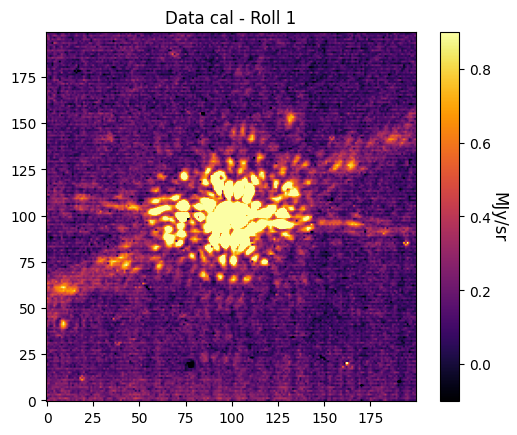

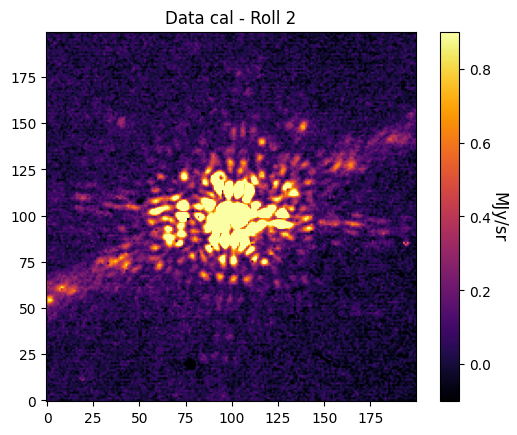

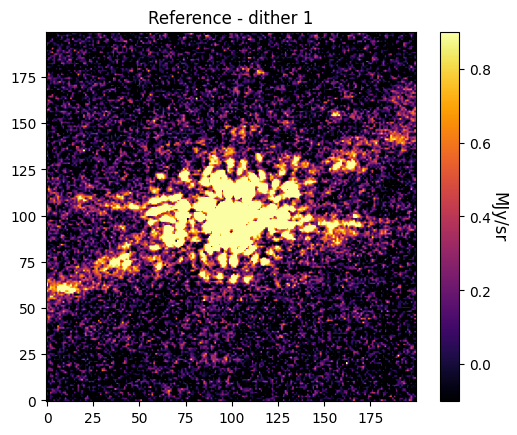

In [10]:
## Plot roll 1 et roll 2
vmin,vmax = -0.1, 0.9
plot(data_red_roll1, vmin , vmax, plot_planet = False, pos_planet=None, title="Data cal - Roll 1", savefig=True, output_dir=output_dir)
plot(data_red_roll2, vmin , vmax, plot_planet = False, pos_planet=None, title="Data cal - Roll 2", savefig=True, output_dir=output_dir)
plot(data_red_ref[0], vmin , vmax, plot_planet = False, pos_planet=None, title="Reference - dither 1", savefig=True, output_dir=output_dir)

## 4. Reference subtraction
##### Focus on roll 1 (better S/N overall)

In [11]:
data_red = data_red_roll1
pa_aper = pa_aper_roll1
files_cal = files_cal_roll1
new_dir = new_dir_roll1

#### 4.1. Classical PCA

In [12]:
# 1st simple red to be able to measure the position of the planet (to measure its S/N)
# Classical PCA :
data_sub_PCA = sub_PCA(data_red_roll2, data_red_ref,new_center,Ktrunc=20)
data_sub_PCA = clean_data(data_sub_PCA)

pos_planet_b = measure_pos_planet(data_sub_PCA, RA_Offset, Dec_Offset, new_center, rotation = True, angle=pa_aper_roll2, plot_fit=False)
pos_planet_b

(101.22304917142277, 86.50161146737132)

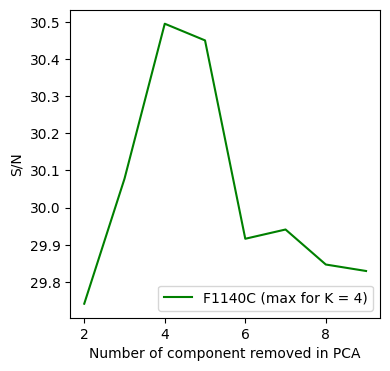

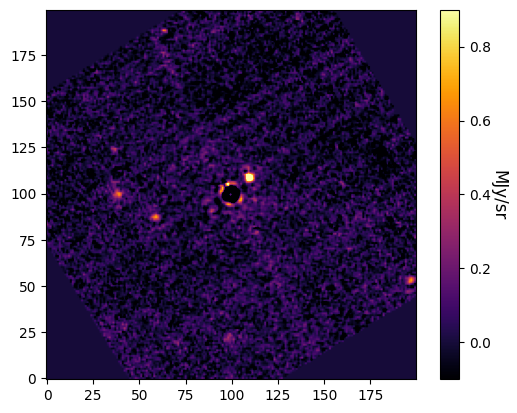

In [13]:
# find the K values that optimize the S/N :
K_list = np.arange(2,10,1)
snr_values = []
for K in K_list:
    try : 
        data_sub_PCA = sub_PCA(data_red, data_red_ref,new_center,Ktrunc=K) 
        snr_values.append(measure_sn(data_sub_PCA, pos_planet_b, new_center, wavelength_filter))
    except :
        snr_values.append(0)
snr_F1140 = [snr_values[i] for i in range(len(K_list))]
Kmax = K_list[np.where(snr_F1140==np.nanmax(snr_F1140))[0][0]]

plt.figure(figsize = (4,4))
plt.plot(K_list, snr_F1140, color='green', label='F1140C (max for K = '+str(Kmax)+')')
#plt.ylim(14,60)
plt.xlabel('Number of component removed in PCA')
plt.ylabel('S/N')
plt.legend()
plt.savefig(new_dir+name_system+'_PCA_Kmax.png')
plt.show()

data_sub_PCA = sub_PCA(data_red, data_red_ref,new_center,Ktrunc=Kmax)
data_sub_PCA = clean_data(data_sub_PCA)
SNR_PCA = measure_sn(data_sub_PCA, pos_planet_b, new_center, wavelength_filter)

data_sub_rot_PCA = rotate_images(data_sub_PCA,new_center,200, -pa_aper) 
new_center_rot = (np.shape(data_sub_rot_PCA)[0]/2, np.shape(data_sub_rot_PCA)[1]/2) 

plot(data_sub_rot_PCA,vmin=vmin,vmax=vmax,savefig=True, output_dir=new_dir+name_system+'_PCA')

save_fits(data_sub_PCA, files_cal, new_dir+name_system+f'_PCA_{filter_name}_norot',
             other_things_to_add = f'Classical PCA ({Kmax} components)')

#### 4.2. 4Q-PCA 

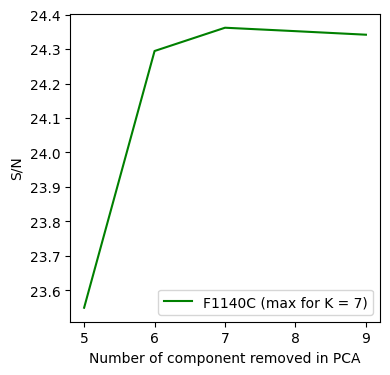

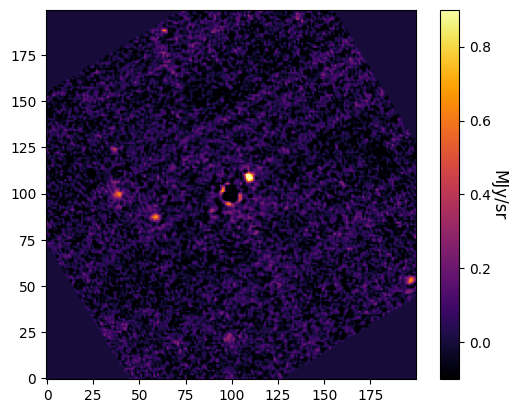

In [14]:
# find the K values that optimize the S/N :
K_list = np.arange(5,10,1)
snr_values = []
for K in K_list:
    try : 
        data_sub_4QPCA = sub_4Q_PCA(data_red, data_red_ref,new_center,K)
        snr_values.append(measure_sn(data_sub_4QPCA, pos_planet_b, new_center, wavelength_filter))
    except :
        snr_values.append(0)

snr_F1140 = [snr_values[i] for i in range(len(K_list))]
Kmax = K_list[np.where(snr_F1140==np.nanmax(snr_F1140))[0][0]]

plt.figure(figsize = (4,4))
plt.plot(K_list, snr_F1140, color='green', label='F1140C (max for K = '+str(Kmax)+')')
plt.xlabel('Number of component removed in PCA')
plt.ylabel('S/N')
plt.legend()
plt.savefig(new_dir+name_system+'_4QPCA_Kmax.png')
plt.show()

data_sub_4QPCA = sub_4Q_PCA(data_red, data_red_ref,new_center, Ktrunc=Kmax)
data_sub_4QPCA = clean_data(data_sub_4QPCA)

SNR_4QPCA = measure_sn(data_sub_4QPCA, pos_planet_b, new_center, wavelength_filter)

data_sub_rot_4QPCA = rotate_images(data_sub_4QPCA,new_center,200, -pa_aper)
new_center_rot = (np.shape(data_sub_rot_4QPCA)[0]/2, np.shape(data_sub_rot_4QPCA)[1]/2) 

plot(data_sub_rot_4QPCA,vmin=vmin,vmax=vmax, savefig=True, output_dir=new_dir+name_system+'_4Q-PCA')

### Save in fits :
save_fits(data_sub_4QPCA, files_cal, new_dir+name_system+f'_4Q-PCA_{filter_name}_norot',
             other_things_to_add = f' PCA applied by quadrant ({Kmax} components)')

#### 4.3. PCA by rings

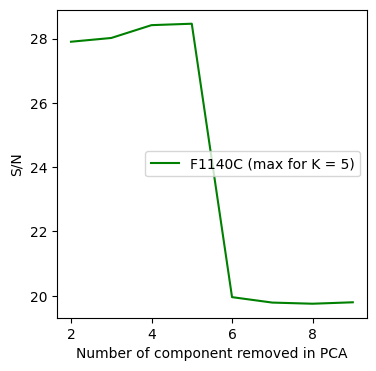

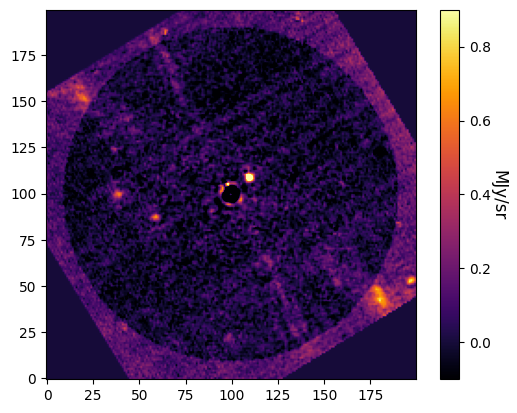

In [15]:
# find the K values that optimize the S/N :
K_list = np.arange(2,10,1)
snr_values = []
for K in K_list:
    try : 
        data_sub_PCA_rings = sub_PCA_rings(data_red, data_red_ref,new_center,K)
        snr_values.append(measure_sn(data_sub_PCA_rings, pos_planet_b, new_center, wavelength_filter))
    except :
        snr_values.append(0)

snr_F1140 = [snr_values[i] for i in range(len(K_list))]
Kmax = K_list[np.where(snr_F1140==np.nanmax(snr_F1140))[0][0]]

plt.figure(figsize = (4,4))
plt.plot(K_list, snr_F1140, color='green', label='F1140C (max for K = '+str(Kmax)+')')
plt.xlabel('Number of component removed in PCA')
plt.ylabel('S/N')
plt.legend()
plt.savefig(new_dir+name_system+'_PCA_rings_Kmax.png')
plt.show()

data_sub_PCA_rings = sub_PCA_rings(data_red, data_red_ref,new_center, Ktrunc=Kmax)
data_sub_PCA_rings = clean_data(data_sub_PCA_rings)

SNR_PCA_rings = measure_sn(data_sub_PCA_rings, pos_planet_b, new_center, wavelength_filter)

data_sub_rot_PCA_rings = rotate_images(data_sub_PCA_rings,new_center,200, -pa_aper)
new_center_rot = (np.shape(data_sub_rot_PCA_rings)[0]/2, np.shape(data_sub_rot_PCA_rings)[1]/2) 

plot(data_sub_rot_PCA_rings,vmin=vmin,vmax=vmax, savefig=True, output_dir=new_dir+name_system+'_4Q-PCA')

### Save in fits :
save_fits(data_sub_PCA_rings, files_cal, new_dir+name_system+f'rings-PCA_{filter_name}_norot',
             other_things_to_add = f' PCA applied by rings ({Kmax} components)')

#### 4.4. Optimized linear combinaison

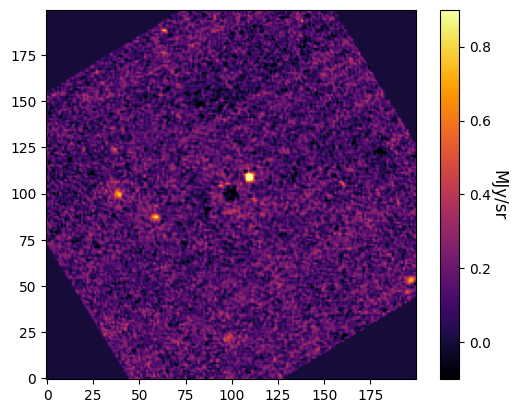

In [16]:
# Linear optimization with all references :
rmin, rmax = 0.3, 0.5
data_sub_OPT = optimize_refs(data_red,data_red_ref, new_center, rmin=rmin, rmax=rmax) # rmin and rmax could be optimized to get the better S/N on the planet's signal
data_sub_OPT = clean_data(data_sub_OPT)

SNR_opt_lin = measure_sn(data_sub_OPT, pos_planet_b, new_center, wavelength_filter)

data_sub_rot_OPT = rotate_images(data_sub_OPT,new_center,200, -pa_aper) 
new_center_rot = (np.shape(data_sub_rot_OPT)[0]/2, np.shape(data_sub_rot_OPT)[1]/2)

plot(data_sub_rot_OPT,vmin=-0.1, vmax=0.9, savefig=True, output_dir=new_dir+name_system+'_opt_lin')

### Save in fits :
save_fits(data_sub_OPT, files_cal, new_dir+name_system+f'_opt_lin_{filter_name}_norot',
          other_things_to_add = f' Optimisation of the linear combinaison')

## 5. Final plot and compare S/N

In [17]:
# Compare S/N for each data reduction :
print(f'S/N PCA = {SNR_PCA}')
print(f'S/N PCA-4Q = {SNR_4QPCA}')
print(f'S/N PCA-rings = {SNR_PCA_rings}')
print(f'S/N opt lin {rmin, rmax} = {SNR_opt_lin}')

S/N PCA = 30.606214738334472
S/N PCA-4Q = 24.362052418768663
S/N PCA-rings = 28.463901260143658
S/N opt lin (0.3, 0.5) = 29.523563857336892


## 6. Contrast curves

In [18]:
# Get the data for the two roll (the part of the notebook needs to be run for both roll)

In [19]:
# data after PSF subtraction
data_sub_roll1 = fits.open(new_dir_roll1+name_system+f'_PCA_{filter_name}_norot.fits')[1].data
data_sub_roll2 = fits.open(new_dir_roll2+name_system+f'_PCA_{filter_name}_norot.fits')[1].data

new_center = np.shape(data_sub_roll1)[0]/2, np.shape(data_sub_roll1)[1]/2

# reduced data - Roll 1 
files_cal = path+f"/stage2_photom/obs{num_obs[0]}/TWA7_dither1_cal.fits" # phtometrically calibrated files in MJy/sec
data_cal = fits.open(files_cal)[1].data
data_clean = clean_data(data_cal)

data_red = scipy.ndimage.shift(np.nan_to_num(data_clean), -offset_center) 
data_red_roll1 = data_red[:a*2,:a*2]

# reduced data - Roll 2 
files_cal = path+f"/stage2_photom/obs{num_obs[0]}/TWA7_dither1_cal.fits" # phtometrically calibrated files in MJy/sec
data_cal = fits.open(files_cal)[1].data
data_clean = clean_data(data_cal)

data_red = scipy.ndimage.shift(np.nan_to_num(data_clean), -offset_center) 
data_red_roll2 = data_red[:a*2,:a*2]

pos_planet_b_roll1 = measure_pos_planet(data_sub_roll1, RA_Offset, Dec_Offset, new_center, rotation = True, angle=pa_aper_roll1, plot_fit=False)
print(f"Planet's position {pos_planet_b_roll1}")
pos_planet_b_roll2 = measure_pos_planet(data_sub_roll2, RA_Offset, Dec_Offset, new_center, rotation = True, angle=pa_aper_roll2, plot_fit=False)
print(f"Planet's position {pos_planet_b_roll2}")

data_sub_rot_PCA_roll1 = rotate_images(data_sub_roll1,new_center,200, -pa_aper_roll1)
data_sub_rot_PCA_roll2 = rotate_images(data_sub_roll2,new_center,200, -pa_aper_roll2)

data_TWA = np.mean([data_sub_rot_PCA_roll1, data_sub_rot_PCA_roll2], axis=0)
data_red = np.mean([data_red_roll1, data_red_roll2], axis=0)
pos_planet_b = measure_pos_planet(data_TWA, RA_Offset, Dec_Offset, new_center, rotation = False, angle=None, plot_fit=False)

Planet's position (102.43942505695273, 86.7063134694344)
Planet's position (101.27082018273688, 86.535823975307)


In [21]:
rmin = int(np.around(0.05/pix_size,0))
rmax = int(np.around(4.4/pix_size,0))

# ROLL 1 
h,w = np.shape(data_sub_roll1)
mask_planet = create_circular_mask(h,w,(pos_planet_b_roll1),1.5*lambdaD_pix)
mask_data = np.ma.array(data_sub_roll1, mask = mask_planet) 
separation_photom, std_photom = meas_contrast(mask_data, iwa=rmin, owa=rmax, resolution=2.5, center=new_center, low_pass_filter=False)
std_conv_roll1 = np.array(std_photom)*pixel_area*1e6*1e-26*299792458e6/(np.array(wavelength_filter))**2    
miri_psf_off_axis_star, max_off_axis_psf, __ = best_off_axis_PSF(data_red_roll1,new_center,'F1065C',rmin=2,rmax=6,
                                                             bounds=((None,None),(-1,1),(-1,1)),
                                                             plot_model=False,vmin=-2,vmax=10) #priors=(1e2,0,0),
contrast_roll1 = std_conv_roll1 / max_off_axis_psf #/ transmission_F1065C_interp

np.savetxt(path+'/Contrast_'+str(name_system)+'_'+str(filter_name)+'_roll1.txt', np.array([separation_photom*pix_size,contrast_roll1]).T)

# ROLL 2
h,w = np.shape(data_sub_roll2)
mask_planet = create_circular_mask(h,w,(pos_planet_b_roll2),1.5*lambdaD_pix)
mask_data = np.ma.array(data_sub_roll2, mask = mask_planet) 
separation_photom, std_photom = meas_contrast(mask_data, iwa=rmin, owa=rmax, resolution=2.5, center=new_center, low_pass_filter=False)
std_conv_roll2 = np.array(std_photom)*pixel_area*1e6*1e-26*299792458e6/(np.array(wavelength_filter))**2    
miri_psf_off_axis_star, max_off_axis_psf, __ = best_off_axis_PSF(data_red_roll2,new_center,'F1065C',rmin=2,rmax=6,
                                                             bounds=((None,None),(-1,1),(-1,1)),
                                                             plot_model=False,vmin=-2,vmax=10) #priors=(1e2,0,0),
contrast_roll2 = std_conv_roll2 / max_off_axis_psf 

np.savetxt(path+'/Contrast_'+str(name_system)+'_'+str(filter_name)+'_roll2.txt', np.array([separation_photom*pix_size,contrast_roll2]).T)

# BOTH ROLL
h,w = np.shape(data_TWA)
mask_planet = create_circular_mask(h,w,(pos_planet_b),1.5*lambdaD_pix)
mask_data = np.ma.array(data_TWA, mask = mask_planet) 
separation_photom, std_photom = meas_contrast(mask_data, iwa=rmin, owa=rmax, resolution=2.5, center=new_center, low_pass_filter=False)
std_conv_bothroll = np.array(std_photom)*pixel_area*1e6*1e-26*299792458e6/(np.array(wavelength_filter))**2    
miri_psf_off_axis_star, max_off_axis_psf, __ = best_off_axis_PSF(data_red,new_center,'F1065C',rmin=2,rmax=6,
                                                             bounds=((None,None),(-1,1),(-1,1)),
                                                             plot_model=False,vmin=-2,vmax=10) #priors=(1e2,0,0),
contrast_bothroll = std_conv_bothroll / max_off_axis_psf 

np.savetxt(path+'/Contrast_'+str(name_system)+'_'+str(filter_name)+'_bothroll.txt', np.array([separation_photom*pix_size,contrast_bothroll]).T)

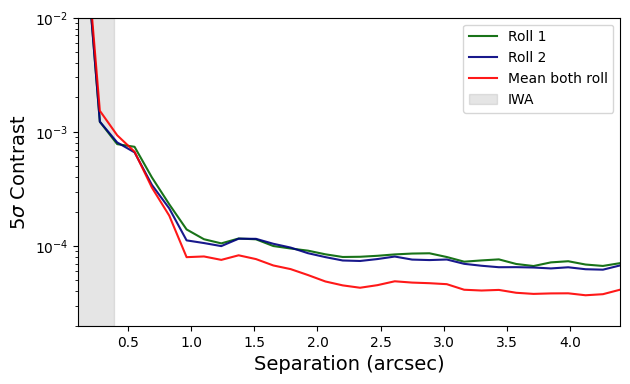

In [22]:
fig,ax = plt.subplots(1,1, figsize=(7,4))

ax.plot(separation_photom*pix_size, contrast_roll1, color='darkgreen', alpha=0.9, label='Roll 1')
ax.plot(separation_photom*pix_size, contrast_roll2, color='navy', alpha=0.9, label='Roll 2')
ax.plot(separation_photom*pix_size, contrast_bothroll, color='red', alpha=0.9, label='Mean both roll')

ax.axes.axvspan(0,0.39,alpha=0.2, color='grey', label='IWA' )

ax.set_yscale('log')
ax.set_xlim(0.1, 4.4)
ax.set_ylim(2e-5, 1e-2)
ax.set_ylabel('5$\sigma$ Contrast ',fontsize=14)
ax.set_xlabel('Separation (arcsec)',fontsize=14)

plt.legend(fontsize=10)
plt.savefig(output_dir+f'Contrast_{name_system}.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

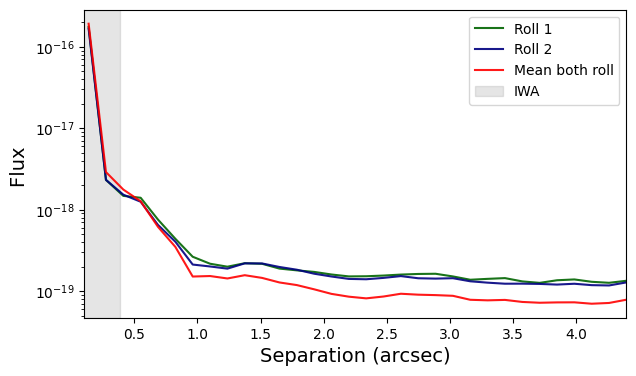

In [23]:
flux_star = 1.89514624e-15

fig,ax = plt.subplots(1,1, figsize=(7,4))

ax.plot(separation_photom*pix_size, contrast_roll1*flux_star, color='darkgreen', alpha=0.9, label='Roll 1')
ax.plot(separation_photom*pix_size, contrast_roll2*flux_star, color='navy', alpha=0.9, label='Roll 2')
ax.plot(separation_photom*pix_size, contrast_bothroll*flux_star, color='red', alpha=0.9, label='Mean both roll')
ax.axes.axvspan(0,0.39,alpha=0.2, color='grey', label='IWA' )

ax.set_yscale('log')
ax.set_xlim(0.1, 4.4)
ax.set_ylabel('Flux ',fontsize=14)
ax.set_xlabel('Separation (arcsec)',fontsize=14)

plt.legend(fontsize=10)
plt.savefig(output_dir+f'Flux_{name_system}.pdf', bbox_inches='tight', pad_inches=0)
plt.show()